# Set-up

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import torch
import xarray as xr
import matplotlib.pyplot as plt

import seqdata as sd

from eugene import preprocess as pp

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
# Paths
data_dir = "/cellar/users/aklie/opt/rbpnet/examples/data"
fasta = "/cellar/users/aklie/data/ref/genomes/hg38/hg38.fa"
out_dir = "/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/training/2023_12_28/HepG2/rbpnet_chr19_U2AF2/"

In [7]:
# TODO: change to your paths
peaks = os.path.join(data_dir, "peaks/U2AF2_HepG2/peaks.crosslink.chr19.bed")
signals = [os.path.join(data_dir, "signal/U2AF2_HepG2/eCLIP/counts.pos.bw"), os.path.join(data_dir, "signal/U2AF2_HepG2/eCLIP/counts.neg.bw")]
controls = [os.path.join(data_dir, "signal/U2AF2_HepG2/control/counts.pos.bw"), os.path.join(data_dir, "signal/U2AF2_HepG2/control/counts.neg.bw")]
bigwigs = signals + controls
sample_names = ['signal+', 'signal-', 'control+', 'control-']
peaks, bigwigs, sample_names

('/cellar/users/aklie/opt/rbpnet/examples/data/peaks/U2AF2_HepG2/peaks.crosslink.chr19.bed',
 ['/cellar/users/aklie/opt/rbpnet/examples/data/signal/U2AF2_HepG2/eCLIP/counts.pos.bw',
  '/cellar/users/aklie/opt/rbpnet/examples/data/signal/U2AF2_HepG2/eCLIP/counts.neg.bw',
  '/cellar/users/aklie/opt/rbpnet/examples/data/signal/U2AF2_HepG2/control/counts.pos.bw',
  '/cellar/users/aklie/opt/rbpnet/examples/data/signal/U2AF2_HepG2/control/counts.neg.bw'],
 ['signal+', 'signal-', 'control+', 'control-'])

In [8]:
# Make output directory if doesn't exist
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
out = os.path.join(out_dir, "all.zarr")
out

# SeqData

In [10]:
sdata = sd.from_region_files(
    sd.GenomeFASTA('seq',
        fasta,
        batch_size=2048,
        n_threads=4,
    ),
    sd.BigWig(
        'cov',
        bigwigs,
        sample_names,
        batch_size=2048,
        n_jobs=4,
        threads_per_job=2,
    ),
    path=out,
    fixed_length=300,
    bed=peaks,
    overwrite=True,
    max_jitter=32
)
sdata.load()

100%|██████████| 1788/1788 [00:00<00:00, 3489.21it/s]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 1788/1788 [00:00<00:00, 2655.26it/s]


<xarray.Dataset>
Dimensions:     (_sequence: 1788, cov_sample: 4, _length: 364)
Coordinates:
  * cov_sample  (cov_sample) object 'signal+' 'signal-' 'control+' 'control-'
Dimensions without coordinates: _sequence, _length
Data variables:
    chrom       (_sequence) object 'chr19' 'chr19' 'chr19' ... 'chr19' 'chr19'
    chromEnd    (_sequence) int64 1373640 13920000 29986452 ... 38709560 6413932
    chromStart  (_sequence) int64 1373276 13919636 29986088 ... 38709196 6413568
    cov         (_sequence, cov_sample, _length) uint16 1 0 0 0 0 ... 0 0 0 0 0
    name        (_sequence) object 'U2AF2_HepG2_rep02' ... 'U2AF2_HepG2_rep02'
    score       (_sequence) float64 6.189 6.111 5.795 ... 2.008 2.006 2.006
    seq         (_sequence, _length) |S1 b'G' b'C' b'C' b'C' ... b'A' b'C' b'C'
    strand      (_sequence) object '+' '+' '+' '+' '+' ... '+' '+' '-' '+' '-'
Attributes:
    length_dim:    _length
    max_jitter:    32
    sequence_dim:  _sequence

In [12]:
# Split cov and control
sdata['signal+'] = (
    sdata.cov.sel(cov_sample=['signal+'])
    .drop_vars("cov_sample").squeeze()
)
sdata['signal-'] = (
    sdata.cov.sel(cov_sample=['signal-'])
    .drop_vars("cov_sample").squeeze()
)
sdata['control+'] = (
    sdata.cov.sel(cov_sample=['control+'])
    .drop_vars("cov_sample").squeeze()
)
sdata['control-'] = (
    sdata.cov.sel(cov_sample=['control-'])
    .drop_vars("cov_sample").squeeze()
)
# Get rid of aggregated cov
sdata = sdata.drop_vars("cov")
sdata = sdata.drop_vars("cov_sample")

In [26]:
# Split into two SeqDatas, one for positive strand and one for negative strand
pos_sdata = sdata.sel(_sequence=sdata["strand"] == "+")
pos_sdata = pos_sdata.drop_vars(["signal-", "control-"])
pos_sdata = pos_sdata.rename_vars({"signal+": "signal", "control+": "control"})
neg_sdata = sdata.sel(_sequence=sdata["strand"] == "-")
neg_sdata = neg_sdata.drop_vars(["signal+", "control+"])
neg_sdata = neg_sdata.rename_vars({"signal-": "signal", "control-": "control"})

In [27]:
# Combine
sdata = xr.concat([pos_sdata, neg_sdata], dim="_sequence")

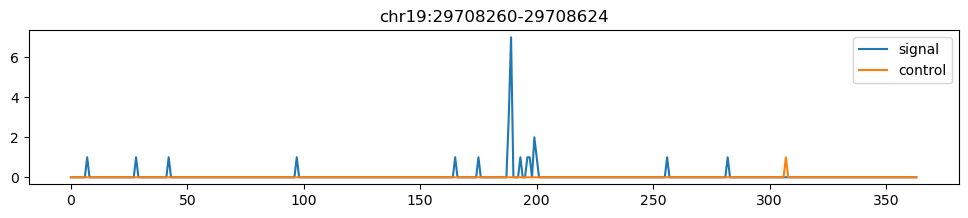

In [33]:
# Plot signal and control
seq_num = 1000
ser = sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_num]
fig, ax = plt.subplots(figsize=(12,2))
plt.plot(sdata["signal"][seq_num].values, label="signal")
plt.plot(sdata["control"][seq_num].values, label="control")
plt.title(ser["chrom"] + ":" + ser["chromStart"].astype(str) + "-" + ser["chromEnd"].astype(str))
plt.legend()

In [34]:
pp.train_test_random_split(sdata, dim="_sequence")

In [35]:
train_sdata = sdata.sel(_sequence=sdata["train_val"])
valid_sdata = sdata.sel(_sequence=~sdata["train_val"])

In [36]:
# Save them
sd.to_zarr(train_sdata, os.path.join(out_dir, 'train.zarr'), mode='w')
sd.to_zarr(valid_sdata, os.path.join(out_dir, 'valid.zarr'), mode='w')

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/conventions.py:112: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/conventions.py:112: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


# DONE!

----